In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

#  Training dataset

Import the training dataset

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "BrainTumorDataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2740 files belonging to 4 classes.


identify the classes in training dataset

In [4]:
class_names = dataset.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

every element in dataset is a batch of 32 images

In [5]:
len(dataset)

86

lets explore the dataset

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 0 3 2 0 3 0 1 0 1 2 2 0 1 3 0 3 3 3 0 2 3 1 0 3 1 3 3 3]


try and print first image

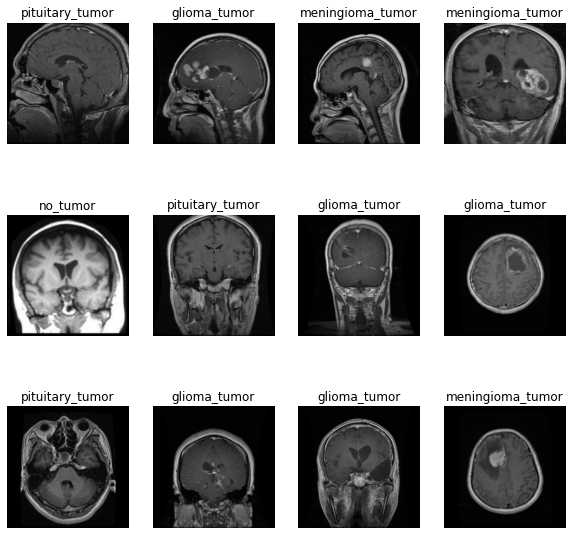

In [7]:
plt.figure(figsize =(10, 10 ))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# train, test and split

In [8]:
len(dataset)

86

we need to split the dataset

80% ==> training  
20% ==> 10% validation, 10% test

10 percent test data can be used to test model performance

In [9]:
train_size = 0.8
len(dataset)*train_size

68.8

so training data has 68.8, we use take(68) method
for test dataset we use the remaining of the data, so we skip(68)

In [10]:
train_data= dataset.take(68)
len(train_data)

68

In [11]:
test_data = dataset.skip(68)
len(test_data)

18

In [12]:
#how much validation data
val_size = 0.1
len(dataset)*val_size

8.6

In [13]:
#take 10 percent for validation
validation_data = test_data.take(8)
len(validation_data)

8

In [14]:
test_data = test_data.skip(8)
len(test_data)

10

In [15]:

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)


68

In [18]:
len(val_ds)

8

In [19]:
len(test_ds)

10

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

prefetch = load the next set of batch to improve performance

# data augmentation 

Data augmentation is needed so we can have more data, this helps the model to become more accurate by having more data

In [21]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS= 3 #3 for red green and blue, 1 for grayscale
EPOCHS=30

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Apply data augmentation to train Dataset

add layers based on trial and error

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4 # because [0,3] means excluding 3, so take 4 units

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

# compile the model

we use adam optimizer, sparseCategoricalCrossentropy for losses
accuracy as metric

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

It seems model failed to compile because the pictures are only black and white, but I am using 3 channels

Black and white only has 1 channel

In [27]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
68/68 [==============================] - 149s 2s/step - loss: 1.1807 - accuracy: 0.4621 - val_loss: 1.0260 - val_accuracy: 0.5391
Epoch 2/30
68/68 [==============================] - 120s 2s/step - loss: 0.8806 - accuracy: 0.6275 - val_loss: 0.6968 - val_accuracy: 0.7031
Epoch 3/30
68/68 [==============================] - 118s 2s/step - loss: 0.6038 - accuracy: 0.7560 - val_loss: 0.4454 - val_accuracy: 0.8398
Epoch 4/30
68/68 [==============================] - 121s 2s/step - loss: 0.4202 - accuracy: 0.8415 - val_loss: 0.4361 - val_accuracy: 0.8203
Epoch 5/30
68/68 [==============================] - 115s 2s/step - loss: 0.3028 - accuracy: 0.8872 - val_loss: 0.2309 - val_accuracy: 0.9141
Epoch 6/30
68/68 [==============================] - 116s 2s/step - loss: 0.2265 - accuracy: 0.9210 - val_loss: 0.1825 - val_accuracy: 0.9453
Epoch 7/30
68/68 [==============================] - 116s 2s/step - loss: 0.1655 - accuracy: 0.9469 - val_loss: 0.1150 - val_accuracy: 0.9727
Epoch 8/30
68

try the model in the test dataset so that it wont be bias, this is the first time our model see our test dataset

In [28]:
score = model.evaluate(test_ds)

10/10 [==============================] - 3s 334ms/step - loss: 0.1105 - accuracy: 0.9805


In [29]:
#accuracy is 0.9805 which is really good
score

[0.11051832884550095, 0.9805194735527039]

# Plot accuracy

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

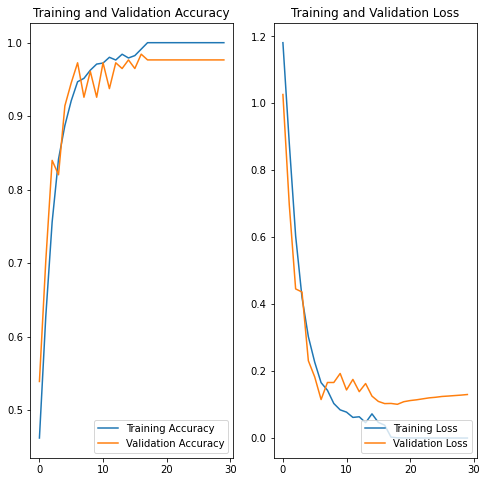

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label ='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label ='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label ='Training Loss')
plt.plot(range(EPOCHS), val_loss, label ='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()


graph shows that after 20 epoch, accuracy is high enough. therefore training for 20 epochs should be enough

Loss = error in backpropagation
it keeps reducing as you go through your epoch

# Test Image prediction

unfortunately since we use softmax, its returning probability, out of the three prediction, the one with the highest will be picked
therefore we use numpy argmax

first image to predict
first image's actual label: glioma_tumor
predicted label: glioma_tumor


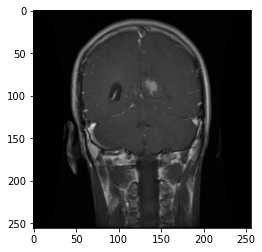

In [33]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])
    
    #model prediction
    batch_prediction = model.predict(images_batch)
    predicted_label = class_names[np.argmax(batch_prediction[0])]
    print("predicted label:", predicted_label)

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) 
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

predict function = take model and image as an input and return the predicted class and its confidence percentage

1. step 1: convert the image into arrays and make a batch out of it 
2. step 2: call prediction function for the image
3. calculate the confidence 

lets run on the first batch

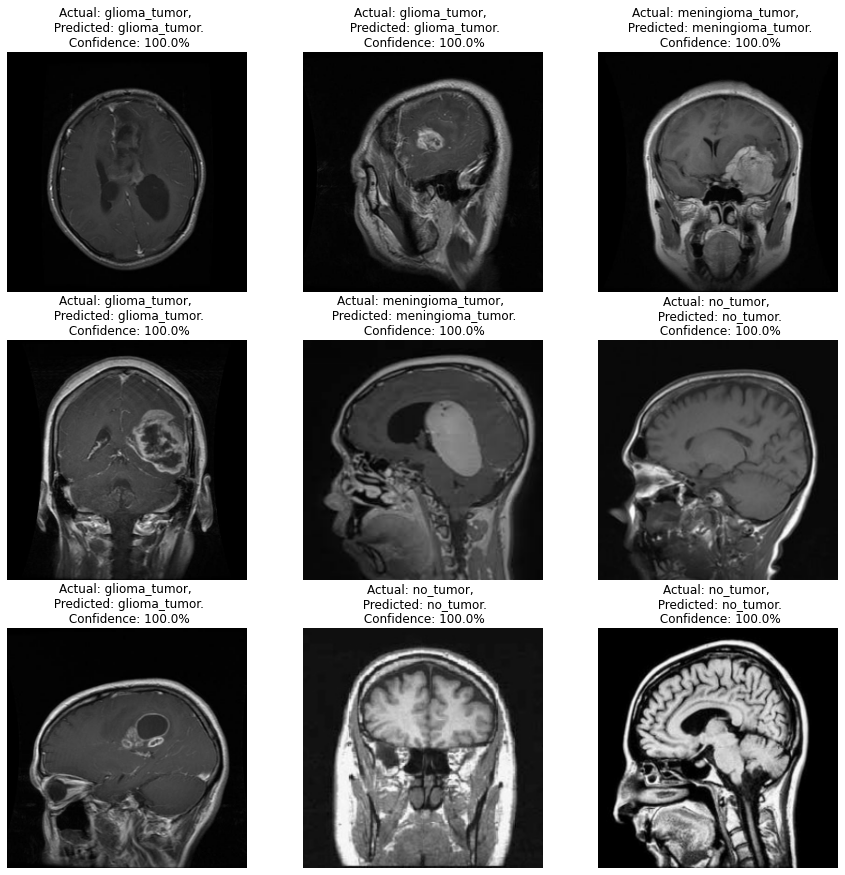

In [35]:
plt.figure(figsize=(15,15)) #size of plot
for images, labels in test_ds.take(1): #take from test data, an image and a label
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        actual_class = class_names[labels[i]]
        #get the predicted label and confidence from predict function that we created
        predicted_class, confidence = predict(model, images[i].numpy())
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [36]:
import os
#everytime we save a model, we increase the version number
#this is to determine, what model version is the newest, create checkpoints and not overwrite
model_version = max([int(i)for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/3\assets
